<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/master/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFcninyavA4mwIglX8U_uTE0HHlH5c7Os99o-5iAovMgJpFraS7eW0
Mounted at /content/drive


In [ ]:
!git clone https://github.com/soukhind2/vgg16obj


In [ ]:
!unzip -q drive/My Drive/obj/data.zip

unzip:  cannot find or open drive/My, drive/My.zip or drive/My.ZIP.


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools





In [ ]:
model = VGG16(weights='imagenet',
              include_top=False)

In [ ]:
model.summary()

In [ ]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data/train/faces/',train_it)
train_it = convertimgs('/content/data/train/scenes/',train_it)
train_it = convertimgs('/content/data/train/objects/',train_it)

val_it = []
val_it = convertimgs('/content/data/val/faces',val_it)
val_it = convertimgs('/content/data/val/scenes',val_it)
val_it = convertimgs('/content/data/val/objects',val_it)

test_it = []
test_it = convertimgs('/content/data/test/faces',test_it)
test_it = convertimgs('/content/data/test/scenes',test_it)
test_it = convertimgs('/content/data/test/objects',test_it)

train_it = np.array(train_it)
val_it = np.array(val_it)
test_it = np.array(test_it)
print(train_it.shape,val_it.shape,test_it.shape)


(1500, 224, 224, 3) (150, 224, 224, 3) (150, 224, 224, 3)


In [ ]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
np.save('features_train' , features_train)
np.save('features_val', features_val)
np.save('features_test', features_test)

Train Time: 6.045823812484741
Val Time: 0.6490285396575928
Test Time: 0.669083833694458


In [ ]:
epochs = 30

train_data = np.load('features_train.npy')
#train_data = features_train
train_labels = [0] * 500 + [1]*500 + [2] * 500
train_labels = to_categorical(train_labels, 3)


val_data = np.load('features_val.npy')
#val_data = features_val
val_labels = [0] * 50 + [1] * 50 + [2] * 50
val_labels = to_categorical(val_labels, 3)

test_data = np.load('features_test.npy')
#test_data = features_test
test_labels = [0] * 50 + [1] * 50 + [2] * 50
test_labels = to_categorical(test_labels, 3)


model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(4096, activation='relu')) 
##model.add(Dropout(0.5)) 
#model.add(Dense(1024, activation='relu')) 
model.add(Dense(3, activation='softmax'))

model.compile(optimizer= Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])
model.save_weights('top_weights',overwrite = True)


Epoch 1/30
24/24 [==============================] - 1s 32ms/step - loss: 0.5225 - accuracy: 0.8953 - val_loss: 0.1883 - val_accuracy: 0.9800
Epoch 2/30
24/24 [==============================] - 1s 26ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.2004 - val_accuracy: 0.9800
Epoch 00002: early stopping


In [ ]:
out = model.evaluate(test_data,test_labels)
print(out)

pred = np.round(model.predict(test_data),0)
#print('rounded test labels',pred)

5/5 [==============================] - 0s 5ms/step - loss: 0.0755 - accuracy: 0.9867
[0.07547084987163544, 0.9866666793823242]


In [ ]:
classes = ['faces','object','scene']
metric = metrics.classification_report(test_labels,pred,target_names = classes)
print(metric)


              precision    recall  f1-score   support

       faces       0.98      1.00      0.99        50
      object       0.98      1.00      0.99        50
       scene       1.00      0.96      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150
 samples avg       0.99      0.99      0.99       150



Confusion matrix, without normalization


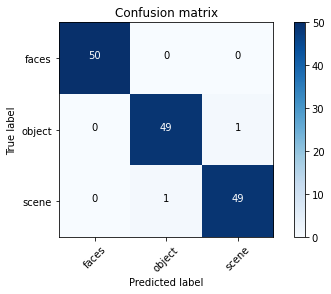

In [ ]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label') 
                                       
plot_confusion_matrix(confusion_matrix,classes,normalize = False)